In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import os

from matplotlib import font_manager, rc
#matplotlib 한글 폰트 오류 문제 해결
font_path='./dataset/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)

## 0. Seed 설정

In [2]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

## 1. 데이터 읽어오기
* 샘플 수 : 6497
* 속성 수 : 12
    * 0: 주석산 농도
    * 1: 아세트산 농도
    * 2: 구연산 농도
    * 3: 잔류 당분 농도
    * 4: 염화나트륨 농도
    * 5: 유리 아황산 농도
    * 6: 총 아황산 농도
    * 7: 밀도
    * 8: pH
    * 9: 황산칼륨 농도
    * 10: 알코올 도수
    * 11: 와인의 맛(0~10등급)    
* 클래스 : 1(레드와인), 0(화이트와인)

In [3]:
df_pre = pd.read_csv('./dataset/wine.csv', header=None, names = ["주석산 농도", "아세트산 농도", "구연산 농도",
                   "잔류 당분 농도", "염화나트륨 농도", "유리 아황산 농도", "총 아황산 농도", "밀도", "pH",
                   "황산칼륨 농도", "알코올 도수", "와인의 맛(0~10등급)", "class"])
# 전체 샘플의 15%만 불러옴
df = df_pre.sample(frac=0.15)

In [4]:
df.head()

,주석산 농도,아세트산 농도,구연산 농도,잔류 당분 농도,염화나트륨 농도,유리 아황산 농도,총 아황산 농도,밀도,pH,황산칼륨 농도,알코올 도수,와인의 맛(0~10등급),class
5316,6.3,0.18,0.24,3.4,0.053,20.0,119.0,0.99373,3.11,0.52,9.2,6,0
5210,6.8,0.14,0.18,1.4,0.047,30.0,90.0,0.99164,3.27,0.54,11.2,6,0
3518,7.3,0.22,0.50,13.7,0.049,56.0,189.0,0.99940,3.24,0.66,9.0,6,0
1622,7.6,0.67,0.14,1.5,0.074,25.0,168.0,0.99370,3.05,0.51,9.3,5,0
2443,7.3,0.21,0.29,1.6,0.034,29.0,118.0,0.99170,3.30,0.50,11.0,8,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975 entries, 5316 to 413
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   주석산 농도         975 non-null    float64
 1   아세트산 농도        975 non-null    float64
 2   구연산 농도         975 non-null    float64
 3   잔류 당분 농도       975 non-null    float64
 4   염화나트륨 농도       975 non-null    float64
 5   유리 아황산 농도      975 non-null    float64
 6   총 아황산 농도       975 non-null    float64
 7   밀도             975 non-null    float64
 8   pH             975 non-null    float64
 9   황산칼륨 농도        975 non-null    float64
 10  알코올 도수         975 non-null    float64
 11  와인의 맛(0~10등급)  975 non-null    int64  
 12  class          975 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 106.6 KB


In [6]:
df.describe()

,주석산 농도,아세트산 농도,구연산 농도,잔류 당분 농도,염화나트륨 농도,유리 아황산 농도,총 아황산 농도,밀도,pH,황산칼륨 농도,알코올 도수,와인의 맛(0~10등급),class
count,975.000000,975.000000,975.000000,975.000000,975.000000,975.000000,975.000000,975.000000,975.000000,975.000000,975.000000,975.000000,975.000000
mean,7.200923,0.334656,0.319610,5.610667,0.056125,30.582564,115.606154,0.994666,3.221118,0.525262,10.524855,5.834872,0.232821
std,1.309666,0.160700,0.146328,4.829183,0.035831,17.039952,54.699109,0.003004,0.163892,0.141601,1.230218,0.877751,0.422846
min,4.200000,0.080000,0.000000,0.800000,0.017000,1.000000,6.000000,0.988230,2.790000,0.250000,8.000000,3.000000,0.000000
25%,6.400000,0.220000,0.250000,1.800000,0.037000,17.000000,81.000000,0.992120,3.110000,0.420000,9.500000,5.000000,0.000000
50%,6.900000,0.290000,0.310000,3.300000,0.047000,29.000000,119.000000,0.994890,3.210000,0.500000,10.300000,6.000000,0.000000
75%,7.600000,0.400000,0.390000,8.200000,0.066000,42.000000,152.000000,0.996890,3.330000,0.600000,11.400000,6.000000,0.000000
max,15.600000,1.040000,1.230000,31.600000,0.415000,118.500000,294.000000,1.010300,3.900000,1.340000,14.000000,9.000000,1.000000


## 2. Attribute, Class 나누기

In [7]:
dataset = df.values
X = dataset[:, 0:12]
Y = dataset[:, 12]

## 3. 모델 설정 

In [8]:
model = Sequential()
model.add(Dense(30, input_dim=12, activation="relu"))
model.add(Dense(12, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

## 4. 모델 컴파일

In [9]:
# class가 이항 분류(binary classification) 문제 이기에 오차 함수는 binary_crossentropy를 사용
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## 5. 모델 저장 설정

In [10]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

## 6. 모델 실행 및 저장

In [11]:
history = model.fit(X, Y, validation_split=0.33, epochs=3500, batch_size=500)

Train on 653 samples, validate on 322 samples
Epoch 1/3500
653/653 [==============================] - 1s 880us/sample - loss: 0.7872 - accuracy: 0.7596 - val_loss: 0.5733 - val_accuracy: 0.7795
Epoch 2/3500
653/653 [==============================] - 0s 38us/sample - loss: 0.5959 - accuracy: 0.7642 - val_loss: 0.4149 - val_accuracy: 0.7826
Epoch 3/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.4435 - accuracy: 0.7688 - val_loss: 0.3259 - val_accuracy: 0.7919
Epoch 4/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.3681 - accuracy: 0.7779 - val_loss: 0.3298 - val_accuracy: 0.8509
Epoch 5/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.3761 - accuracy: 0.8224 - val_loss: 0.3459 - val_accuracy: 0.9130
Epoch 6/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.3811 - accuracy: 0.8698 - val_loss: 0.3316 - val_accuracy: 0.9161
Epoch 7/3500
653/653 [==============================] - 0s 21us/sample 

653/653 [==============================] - 0s 21us/sample - loss: 0.2131 - accuracy: 0.9250 - val_loss: 0.2122 - val_accuracy: 0.9348
Epoch 57/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.2120 - accuracy: 0.9280 - val_loss: 0.2111 - val_accuracy: 0.9348
Epoch 58/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.2113 - accuracy: 0.9296 - val_loss: 0.2101 - val_accuracy: 0.9379
Epoch 59/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.2102 - accuracy: 0.9296 - val_loss: 0.2093 - val_accuracy: 0.9379
Epoch 60/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.2095 - accuracy: 0.9296 - val_loss: 0.2080 - val_accuracy: 0.9379
Epoch 61/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.2085 - accuracy: 0.9296 - val_loss: 0.2066 - val_accuracy: 0.9410
Epoch 62/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.2075 - accuracy: 0.9280 - val_loss: 0.2049 -

653/653 [==============================] - 0s 21us/sample - loss: 0.1855 - accuracy: 0.9357 - val_loss: 0.1849 - val_accuracy: 0.9472
Epoch 112/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.1856 - accuracy: 0.9342 - val_loss: 0.1854 - val_accuracy: 0.9441
Epoch 113/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.1853 - accuracy: 0.9342 - val_loss: 0.1848 - val_accuracy: 0.9472
Epoch 114/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.1847 - accuracy: 0.9357 - val_loss: 0.1840 - val_accuracy: 0.9503
Epoch 115/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.1843 - accuracy: 0.9357 - val_loss: 0.1837 - val_accuracy: 0.9503
Epoch 116/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1844 - accuracy: 0.9357 - val_loss: 0.1835 - val_accuracy: 0.9503
Epoch 117/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.1840 - accuracy: 0.9372 - val_loss: 0.

653/653 [==============================] - 0s 24us/sample - loss: 0.1678 - accuracy: 0.9357 - val_loss: 0.1656 - val_accuracy: 0.9472
Epoch 167/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.1674 - accuracy: 0.9357 - val_loss: 0.1655 - val_accuracy: 0.9472
Epoch 168/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1675 - accuracy: 0.9342 - val_loss: 0.1662 - val_accuracy: 0.9472
Epoch 169/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.1680 - accuracy: 0.9342 - val_loss: 0.1652 - val_accuracy: 0.9472
Epoch 170/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1676 - accuracy: 0.9342 - val_loss: 0.1640 - val_accuracy: 0.9441
Epoch 171/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1664 - accuracy: 0.9357 - val_loss: 0.1642 - val_accuracy: 0.9441
Epoch 172/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.1665 - accuracy: 0.9357 - val_loss: 0.

653/653 [==============================] - 0s 21us/sample - loss: 0.1514 - accuracy: 0.9372 - val_loss: 0.1513 - val_accuracy: 0.9441
Epoch 222/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.1502 - accuracy: 0.9372 - val_loss: 0.1526 - val_accuracy: 0.9472
Epoch 223/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.1505 - accuracy: 0.9372 - val_loss: 0.1521 - val_accuracy: 0.9472
Epoch 224/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.1500 - accuracy: 0.9357 - val_loss: 0.1503 - val_accuracy: 0.9441
Epoch 225/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.1492 - accuracy: 0.9357 - val_loss: 0.1496 - val_accuracy: 0.9441
Epoch 226/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1489 - accuracy: 0.9357 - val_loss: 0.1496 - val_accuracy: 0.9441
Epoch 227/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1486 - accuracy: 0.9372 - val_loss: 0.

653/653 [==============================] - 0s 18us/sample - loss: 0.1278 - accuracy: 0.9403 - val_loss: 0.1281 - val_accuracy: 0.9472
Epoch 277/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1295 - accuracy: 0.9418 - val_loss: 0.1251 - val_accuracy: 0.9503
Epoch 278/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.1270 - accuracy: 0.9403 - val_loss: 0.1224 - val_accuracy: 0.9503
Epoch 279/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.1264 - accuracy: 0.9403 - val_loss: 0.1227 - val_accuracy: 0.9503
Epoch 280/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.1276 - accuracy: 0.9403 - val_loss: 0.1215 - val_accuracy: 0.9503
Epoch 281/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.1248 - accuracy: 0.9418 - val_loss: 0.1233 - val_accuracy: 0.9503
Epoch 282/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.1265 - accuracy: 0.9418 - val_loss: 0.

Epoch 331/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.1106 - accuracy: 0.9525 - val_loss: 0.1070 - val_accuracy: 0.9534
Epoch 332/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1061 - accuracy: 0.9510 - val_loss: 0.1047 - val_accuracy: 0.9534
Epoch 333/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.1092 - accuracy: 0.9632 - val_loss: 0.1036 - val_accuracy: 0.9534
Epoch 334/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.1069 - accuracy: 0.9556 - val_loss: 0.1065 - val_accuracy: 0.9472
Epoch 335/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.1072 - accuracy: 0.9495 - val_loss: 0.1051 - val_accuracy: 0.9503
Epoch 336/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.1067 - accuracy: 0.9510 - val_loss: 0.1032 - val_accuracy: 0.9534
Epoch 337/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.1056 - accuracy: 0.9541

Epoch 386/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0905 - accuracy: 0.9602 - val_loss: 0.0964 - val_accuracy: 0.9534
Epoch 387/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0905 - accuracy: 0.9602 - val_loss: 0.0947 - val_accuracy: 0.9565
Epoch 388/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0893 - accuracy: 0.9694 - val_loss: 0.0931 - val_accuracy: 0.9565
Epoch 389/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0913 - accuracy: 0.9724 - val_loss: 0.0937 - val_accuracy: 0.9565
Epoch 390/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0887 - accuracy: 0.9694 - val_loss: 0.0996 - val_accuracy: 0.9565
Epoch 391/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0926 - accuracy: 0.9556 - val_loss: 0.0960 - val_accuracy: 0.9565
Epoch 392/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0892 - accuracy: 0.9678

Epoch 441/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0792 - accuracy: 0.9724 - val_loss: 0.0893 - val_accuracy: 0.9627
Epoch 442/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0808 - accuracy: 0.9648 - val_loss: 0.0853 - val_accuracy: 0.9627
Epoch 443/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0782 - accuracy: 0.9694 - val_loss: 0.0836 - val_accuracy: 0.9658
Epoch 444/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0780 - accuracy: 0.9709 - val_loss: 0.0837 - val_accuracy: 0.9658
Epoch 445/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0773 - accuracy: 0.9724 - val_loss: 0.0843 - val_accuracy: 0.9627
Epoch 446/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0768 - accuracy: 0.9740 - val_loss: 0.0872 - val_accuracy: 0.9627
Epoch 447/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0783 - accuracy: 0.9694

Epoch 496/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0708 - accuracy: 0.9724 - val_loss: 0.0800 - val_accuracy: 0.9689
Epoch 497/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0670 - accuracy: 0.9755 - val_loss: 0.0761 - val_accuracy: 0.9658
Epoch 498/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0743 - accuracy: 0.9724 - val_loss: 0.0754 - val_accuracy: 0.9720
Epoch 499/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0678 - accuracy: 0.9755 - val_loss: 0.0847 - val_accuracy: 0.9627
Epoch 500/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0715 - accuracy: 0.9709 - val_loss: 0.0833 - val_accuracy: 0.9689
Epoch 501/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0701 - accuracy: 0.9709 - val_loss: 0.0750 - val_accuracy: 0.9752
Epoch 502/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0690 - accuracy: 0.9755

Epoch 551/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0588 - accuracy: 0.9801 - val_loss: 0.0709 - val_accuracy: 0.9752
Epoch 552/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0604 - accuracy: 0.9801 - val_loss: 0.0716 - val_accuracy: 0.9752
Epoch 553/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0601 - accuracy: 0.9755 - val_loss: 0.0742 - val_accuracy: 0.9720
Epoch 554/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0597 - accuracy: 0.9770 - val_loss: 0.0726 - val_accuracy: 0.9720
Epoch 555/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0590 - accuracy: 0.9770 - val_loss: 0.0709 - val_accuracy: 0.9720
Epoch 556/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0582 - accuracy: 0.9801 - val_loss: 0.0697 - val_accuracy: 0.9752
Epoch 557/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0586 - accuracy: 0.9801

Epoch 606/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0541 - accuracy: 0.9816 - val_loss: 0.0632 - val_accuracy: 0.9752
Epoch 607/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0549 - accuracy: 0.9801 - val_loss: 0.0680 - val_accuracy: 0.9720
Epoch 608/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0540 - accuracy: 0.9816 - val_loss: 0.0695 - val_accuracy: 0.9720
Epoch 609/3500
653/653 [==============================] - 0s 35us/sample - loss: 0.0520 - accuracy: 0.9847 - val_loss: 0.0630 - val_accuracy: 0.9752
Epoch 610/3500
653/653 [==============================] - 0s 37us/sample - loss: 0.0559 - accuracy: 0.9786 - val_loss: 0.0641 - val_accuracy: 0.9752
Epoch 611/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0529 - accuracy: 0.9847 - val_loss: 0.0744 - val_accuracy: 0.9720
Epoch 612/3500
653/653 [==============================] - 0s 27us/sample - loss: 0.0554 - accuracy: 0.9816

Epoch 661/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0489 - accuracy: 0.9832 - val_loss: 0.0633 - val_accuracy: 0.9783
Epoch 662/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0476 - accuracy: 0.9801 - val_loss: 0.0663 - val_accuracy: 0.9752
Epoch 663/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0488 - accuracy: 0.9847 - val_loss: 0.0619 - val_accuracy: 0.9783
Epoch 664/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0464 - accuracy: 0.9832 - val_loss: 0.0629 - val_accuracy: 0.9783
Epoch 665/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0463 - accuracy: 0.9862 - val_loss: 0.0643 - val_accuracy: 0.9783
Epoch 666/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0465 - accuracy: 0.9862 - val_loss: 0.0613 - val_accuracy: 0.9783
Epoch 667/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0458 - accuracy: 0.9832

Epoch 716/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0423 - accuracy: 0.9862 - val_loss: 0.0637 - val_accuracy: 0.9783
Epoch 717/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0435 - accuracy: 0.9832 - val_loss: 0.0640 - val_accuracy: 0.9783
Epoch 718/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0432 - accuracy: 0.9847 - val_loss: 0.0576 - val_accuracy: 0.9752
Epoch 719/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0435 - accuracy: 0.9862 - val_loss: 0.0573 - val_accuracy: 0.9783
Epoch 720/3500
653/653 [==============================] - 0s 15us/sample - loss: 0.0447 - accuracy: 0.9862 - val_loss: 0.0625 - val_accuracy: 0.9783
Epoch 721/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0430 - accuracy: 0.9862 - val_loss: 0.0682 - val_accuracy: 0.9720
Epoch 722/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0463 - accuracy: 0.9847

Epoch 771/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0381 - accuracy: 0.9893 - val_loss: 0.0535 - val_accuracy: 0.9783
Epoch 772/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0366 - accuracy: 0.9893 - val_loss: 0.0544 - val_accuracy: 0.9783
Epoch 773/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.0581 - val_accuracy: 0.9752
Epoch 774/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0368 - accuracy: 0.9877 - val_loss: 0.0582 - val_accuracy: 0.9752
Epoch 775/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0365 - accuracy: 0.9877 - val_loss: 0.0565 - val_accuracy: 0.9752
Epoch 776/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0367 - accuracy: 0.9893 - val_loss: 0.0534 - val_accuracy: 0.9752
Epoch 777/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0395 - accuracy: 0.9893

Epoch 826/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0337 - accuracy: 0.9908 - val_loss: 0.0525 - val_accuracy: 0.9752
Epoch 827/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0342 - accuracy: 0.9923 - val_loss: 0.0544 - val_accuracy: 0.9783
Epoch 828/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.0568 - val_accuracy: 0.9783
Epoch 829/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0338 - accuracy: 0.9893 - val_loss: 0.0540 - val_accuracy: 0.9783
Epoch 830/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.0526 - val_accuracy: 0.9783
Epoch 831/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0333 - accuracy: 0.9893 - val_loss: 0.0535 - val_accuracy: 0.9783
Epoch 832/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0332 - accuracy: 0.9893

Epoch 881/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0308 - accuracy: 0.9939 - val_loss: 0.0606 - val_accuracy: 0.9720
Epoch 882/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0349 - accuracy: 0.9908 - val_loss: 0.0547 - val_accuracy: 0.9783
Epoch 883/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0307 - accuracy: 0.9908 - val_loss: 0.0507 - val_accuracy: 0.9814
Epoch 884/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0372 - accuracy: 0.9908 - val_loss: 0.0518 - val_accuracy: 0.9783
Epoch 885/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.0684 - val_accuracy: 0.9689
Epoch 886/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.0598 - val_accuracy: 0.9752
Epoch 887/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0316 - accuracy: 0.9923

Epoch 936/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0313 - accuracy: 0.9923 - val_loss: 0.0500 - val_accuracy: 0.9814
Epoch 937/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0291 - accuracy: 0.9939 - val_loss: 0.0495 - val_accuracy: 0.9814
Epoch 938/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0312 - accuracy: 0.9908 - val_loss: 0.0536 - val_accuracy: 0.9783
Epoch 939/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0299 - accuracy: 0.9893 - val_loss: 0.0582 - val_accuracy: 0.9783
Epoch 940/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0308 - accuracy: 0.9908 - val_loss: 0.0522 - val_accuracy: 0.9783
Epoch 941/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0286 - accuracy: 0.9939 - val_loss: 0.0518 - val_accuracy: 0.9783
Epoch 942/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0284 - accuracy: 0.9939

Epoch 991/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0267 - accuracy: 0.9954 - val_loss: 0.0523 - val_accuracy: 0.9814
Epoch 992/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0268 - accuracy: 0.9939 - val_loss: 0.0540 - val_accuracy: 0.9814
Epoch 993/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0267 - accuracy: 0.9939 - val_loss: 0.0556 - val_accuracy: 0.9814
Epoch 994/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0274 - accuracy: 0.9908 - val_loss: 0.0554 - val_accuracy: 0.9814
Epoch 995/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0277 - accuracy: 0.9908 - val_loss: 0.0525 - val_accuracy: 0.9814
Epoch 996/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0265 - accuracy: 0.9939 - val_loss: 0.0520 - val_accuracy: 0.9814
Epoch 997/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0307 - accuracy: 0.9908

Epoch 1046/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0274 - accuracy: 0.9923 - val_loss: 0.0521 - val_accuracy: 0.9845
Epoch 1047/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0252 - accuracy: 0.9954 - val_loss: 0.0546 - val_accuracy: 0.9783
Epoch 1048/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0256 - accuracy: 0.9908 - val_loss: 0.0523 - val_accuracy: 0.9814
Epoch 1049/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0248 - accuracy: 0.9969 - val_loss: 0.0505 - val_accuracy: 0.9814
Epoch 1050/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0276 - accuracy: 0.9908 - val_loss: 0.0515 - val_accuracy: 0.9845
Epoch 1051/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0258 - accuracy: 0.9954 - val_loss: 0.0578 - val_accuracy: 0.9814
Epoch 1052/3500
653/653 [==============================] - 0s 27us/sample - loss: 0.0272 - accuracy:

653/653 [==============================] - 0s 21us/sample - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0.0543 - val_accuracy: 0.9783
Epoch 1101/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.0520 - val_accuracy: 0.9814
Epoch 1102/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0241 - accuracy: 0.9969 - val_loss: 0.0491 - val_accuracy: 0.9814
Epoch 1103/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.0499 - val_accuracy: 0.9814
Epoch 1104/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0240 - accuracy: 0.9954 - val_loss: 0.0529 - val_accuracy: 0.9814
Epoch 1105/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.0505 - val_accuracy: 0.9814
Epoch 1106/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0240 - accuracy: 0.9969 - val_lo

Epoch 1155/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0.0557 - val_accuracy: 0.9814
Epoch 1156/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0244 - accuracy: 0.9939 - val_loss: 0.0520 - val_accuracy: 0.9814
Epoch 1157/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0230 - accuracy: 0.9954 - val_loss: 0.0530 - val_accuracy: 0.9845
Epoch 1158/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0226 - accuracy: 0.9954 - val_loss: 0.0555 - val_accuracy: 0.9814
Epoch 1159/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0236 - accuracy: 0.9939 - val_loss: 0.0522 - val_accuracy: 0.9814
Epoch 1160/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0219 - accuracy: 0.9969 - val_loss: 0.0522 - val_accuracy: 0.9783
Epoch 1161/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0270 - accuracy:

653/653 [==============================] - 0s 20us/sample - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.0537 - val_accuracy: 0.9814
Epoch 1210/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0220 - accuracy: 0.9969 - val_loss: 0.0542 - val_accuracy: 0.9814
Epoch 1211/3500
653/653 [==============================] - 0s 30us/sample - loss: 0.0234 - accuracy: 0.9939 - val_loss: 0.0559 - val_accuracy: 0.9845
Epoch 1212/3500
653/653 [==============================] - 0s 27us/sample - loss: 0.0218 - accuracy: 0.9954 - val_loss: 0.0604 - val_accuracy: 0.9814
Epoch 1213/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0253 - accuracy: 0.9908 - val_loss: 0.0544 - val_accuracy: 0.9845
Epoch 1214/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0215 - accuracy: 0.9954 - val_loss: 0.0523 - val_accuracy: 0.9814
Epoch 1215/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0232 - accuracy: 0.9939 - val_lo

Epoch 1264/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0220 - accuracy: 0.9954 - val_loss: 0.0552 - val_accuracy: 0.9814
Epoch 1265/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0205 - accuracy: 0.9969 - val_loss: 0.0604 - val_accuracy: 0.9814
Epoch 1266/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0231 - accuracy: 0.9939 - val_loss: 0.0602 - val_accuracy: 0.9814
Epoch 1267/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0233 - accuracy: 0.9939 - val_loss: 0.0555 - val_accuracy: 0.9814
Epoch 1268/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0208 - accuracy: 0.9969 - val_loss: 0.0557 - val_accuracy: 0.9814
Epoch 1269/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0206 - accuracy: 0.9969 - val_loss: 0.0571 - val_accuracy: 0.9845
Epoch 1270/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0220 - accuracy:

653/653 [==============================] - 0s 23us/sample - loss: 0.0197 - accuracy: 0.9969 - val_loss: 0.0565 - val_accuracy: 0.9720
Epoch 1319/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0245 - accuracy: 0.9908 - val_loss: 0.0536 - val_accuracy: 0.9814
Epoch 1320/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0203 - accuracy: 0.9969 - val_loss: 0.0569 - val_accuracy: 0.9845
Epoch 1321/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0544 - val_accuracy: 0.9845
Epoch 1322/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0201 - accuracy: 0.9969 - val_loss: 0.0548 - val_accuracy: 0.9783
Epoch 1323/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0562 - val_accuracy: 0.9845
Epoch 1324/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0253 - accuracy: 0.9908 - val_lo

Epoch 1373/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0204 - accuracy: 0.9939 - val_loss: 0.0546 - val_accuracy: 0.9783
Epoch 1374/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0204 - accuracy: 0.9954 - val_loss: 0.0552 - val_accuracy: 0.9783
Epoch 1375/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0204 - accuracy: 0.9939 - val_loss: 0.0561 - val_accuracy: 0.9814
Epoch 1376/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0191 - accuracy: 0.9969 - val_loss: 0.0584 - val_accuracy: 0.9845
Epoch 1377/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0201 - accuracy: 0.9954 - val_loss: 0.0594 - val_accuracy: 0.9845
Epoch 1378/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0200 - accuracy: 0.9954 - val_loss: 0.0579 - val_accuracy: 0.9845
Epoch 1379/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0195 - accuracy:

653/653 [==============================] - 0s 18us/sample - loss: 0.0212 - accuracy: 0.9939 - val_loss: 0.0545 - val_accuracy: 0.9814
Epoch 1428/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0190 - accuracy: 0.9969 - val_loss: 0.0546 - val_accuracy: 0.9783
Epoch 1429/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0195 - accuracy: 0.9939 - val_loss: 0.0551 - val_accuracy: 0.9845
Epoch 1430/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0187 - accuracy: 0.9954 - val_loss: 0.0577 - val_accuracy: 0.9814
Epoch 1431/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0204 - accuracy: 0.9954 - val_loss: 0.0557 - val_accuracy: 0.9845
Epoch 1432/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0183 - accuracy: 0.9969 - val_loss: 0.0564 - val_accuracy: 0.9752
Epoch 1433/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0200 - accuracy: 0.9939 - val_lo

653/653 [==============================] - 0s 20us/sample - loss: 0.0213 - accuracy: 0.9923 - val_loss: 0.0586 - val_accuracy: 0.9783
Epoch 1482/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0209 - accuracy: 0.9923 - val_loss: 0.0609 - val_accuracy: 0.9845
Epoch 1483/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0199 - accuracy: 0.9954 - val_loss: 0.0603 - val_accuracy: 0.9845
Epoch 1484/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0196 - accuracy: 0.9954 - val_loss: 0.0571 - val_accuracy: 0.9783
Epoch 1485/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.0611 - val_accuracy: 0.9689
Epoch 1486/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0233 - accuracy: 0.9923 - val_loss: 0.0606 - val_accuracy: 0.9814
Epoch 1487/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0206 - accuracy: 0.9954 - val_lo

Epoch 1536/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0381 - accuracy: 0.9862 - val_loss: 0.0572 - val_accuracy: 0.9783
Epoch 1537/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0267 - accuracy: 0.9939 - val_loss: 0.0848 - val_accuracy: 0.9689
Epoch 1538/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0474 - accuracy: 0.9755 - val_loss: 0.0678 - val_accuracy: 0.9752
Epoch 1539/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0355 - accuracy: 0.9847 - val_loss: 0.0708 - val_accuracy: 0.9752
Epoch 1540/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0314 - accuracy: 0.9877 - val_loss: 0.0584 - val_accuracy: 0.9720
Epoch 1541/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0242 - accuracy: 0.9893 - val_loss: 0.0632 - val_accuracy: 0.9689
Epoch 1542/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0311 - accuracy:

653/653 [==============================] - 0s 21us/sample - loss: 0.0185 - accuracy: 0.9969 - val_loss: 0.0772 - val_accuracy: 0.9752
Epoch 1591/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0488 - accuracy: 0.9801 - val_loss: 0.0509 - val_accuracy: 0.9814
Epoch 1592/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.0818 - val_accuracy: 0.9783
Epoch 1593/3500
653/653 [==============================] - 0s 27us/sample - loss: 0.0492 - accuracy: 0.9816 - val_loss: 0.0604 - val_accuracy: 0.9814
Epoch 1594/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0251 - accuracy: 0.9908 - val_loss: 0.0738 - val_accuracy: 0.9720
Epoch 1595/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0389 - accuracy: 0.9832 - val_loss: 0.0609 - val_accuracy: 0.9720
Epoch 1596/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0247 - accuracy: 0.9893 - val_lo

Epoch 1645/3500
653/653 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.00 - 0s 20us/sample - loss: 0.0168 - accuracy: 0.9969 - val_loss: 0.0667 - val_accuracy: 0.9814
Epoch 1646/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0160 - accuracy: 0.9969 - val_loss: 0.0699 - val_accuracy: 0.9783
Epoch 1647/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0192 - accuracy: 0.9923 - val_loss: 0.0700 - val_accuracy: 0.9783
Epoch 1648/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0204 - accuracy: 0.9923 - val_loss: 0.0633 - val_accuracy: 0.9783
Epoch 1649/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0171 - accuracy: 0.9969 - val_loss: 0.0631 - val_accuracy: 0.9814
Epoch 1650/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0180 - accuracy: 0.9939 - val_loss: 0.0638 - val_accuracy: 0.9814
Epoch 1651/3500
653/653 [==============================] -

Epoch 1699/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0161 - accuracy: 0.9969 - val_loss: 0.0734 - val_accuracy: 0.9814
Epoch 1700/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.0720 - val_accuracy: 0.9814
Epoch 1701/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0686 - val_accuracy: 0.9814
Epoch 1702/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0157 - accuracy: 0.9969 - val_loss: 0.0668 - val_accuracy: 0.9783
Epoch 1703/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.0645 - val_accuracy: 0.9783
Epoch 1704/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.0638 - val_accuracy: 0.9814
Epoch 1705/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0175 - accuracy:

653/653 [==============================] - 0s 18us/sample - loss: 0.0159 - accuracy: 0.9954 - val_loss: 0.0633 - val_accuracy: 0.9783
Epoch 1754/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.0644 - val_accuracy: 0.9814
Epoch 1755/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0670 - val_accuracy: 0.9814
Epoch 1756/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0162 - accuracy: 0.9969 - val_loss: 0.0690 - val_accuracy: 0.9814
Epoch 1757/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0149 - accuracy: 0.9969 - val_loss: 0.0710 - val_accuracy: 0.9783
Epoch 1758/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0179 - accuracy: 0.9923 - val_loss: 0.0680 - val_accuracy: 0.9783
Epoch 1759/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0153 - accuracy: 0.9954 - val_lo

Epoch 1808/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0165 - accuracy: 0.9969 - val_loss: 0.0759 - val_accuracy: 0.9814
Epoch 1809/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0145 - accuracy: 0.9969 - val_loss: 0.0798 - val_accuracy: 0.9720
Epoch 1810/3500
653/653 [==============================] - 0s 22us/sample - loss: 0.0196 - accuracy: 0.9908 - val_loss: 0.0761 - val_accuracy: 0.9783
Epoch 1811/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0168 - accuracy: 0.9939 - val_loss: 0.0711 - val_accuracy: 0.9814
Epoch 1812/3500
653/653 [==============================] - 0s 31us/sample - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0692 - val_accuracy: 0.9814
Epoch 1813/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.0683 - val_accuracy: 0.9783
Epoch 1814/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0187 - accuracy:

653/653 [==============================] - 0s 21us/sample - loss: 0.0145 - accuracy: 0.9969 - val_loss: 0.0794 - val_accuracy: 0.9783
Epoch 1863/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0154 - accuracy: 0.9954 - val_loss: 0.0793 - val_accuracy: 0.9783
Epoch 1864/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0162 - accuracy: 0.9939 - val_loss: 0.0732 - val_accuracy: 0.9783
Epoch 1865/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.0707 - val_accuracy: 0.9814
Epoch 1866/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.0712 - val_accuracy: 0.9814
Epoch 1867/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0150 - accuracy: 0.9969 - val_loss: 0.0748 - val_accuracy: 0.9783
Epoch 1868/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0145 - accuracy: 0.9954 - val_lo

Epoch 1917/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0139 - accuracy: 0.9969 - val_loss: 0.0812 - val_accuracy: 0.9783
Epoch 1918/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.0841 - val_accuracy: 0.9783
Epoch 1919/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.0849 - val_accuracy: 0.9814
Epoch 1920/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0160 - accuracy: 0.9969 - val_loss: 0.0867 - val_accuracy: 0.9783
Epoch 1921/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0174 - accuracy: 0.9939 - val_loss: 0.0835 - val_accuracy: 0.9814
Epoch 1922/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0142 - accuracy: 0.9969 - val_loss: 0.0827 - val_accuracy: 0.9783
Epoch 1923/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0154 - accuracy:

653/653 [==============================] - 0s 18us/sample - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0811 - val_accuracy: 0.9814
Epoch 1972/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0135 - accuracy: 0.9954 - val_loss: 0.0805 - val_accuracy: 0.9814
Epoch 1973/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.0808 - val_accuracy: 0.9814
Epoch 1974/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0133 - accuracy: 0.9969 - val_loss: 0.0835 - val_accuracy: 0.9783
Epoch 1975/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0161 - accuracy: 0.9939 - val_loss: 0.0829 - val_accuracy: 0.9783
Epoch 1976/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0139 - accuracy: 0.9954 - val_loss: 0.0832 - val_accuracy: 0.9814
Epoch 1977/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0167 - accuracy: 0.9954 - val_lo

Epoch 2026/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0147 - accuracy: 0.9939 - val_loss: 0.0885 - val_accuracy: 0.9783
Epoch 2027/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.0922 - val_accuracy: 0.9720
Epoch 2028/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0207 - accuracy: 0.9908 - val_loss: 0.0861 - val_accuracy: 0.9783
Epoch 2029/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.0823 - val_accuracy: 0.9814
Epoch 2030/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0171 - accuracy: 0.9954 - val_loss: 0.0875 - val_accuracy: 0.9814
Epoch 2031/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0180 - accuracy: 0.9939 - val_loss: 0.0932 - val_accuracy: 0.9783
Epoch 2032/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0132 - accuracy:

653/653 [==============================] - 0s 23us/sample - loss: 0.0147 - accuracy: 0.9939 - val_loss: 0.0899 - val_accuracy: 0.9783
Epoch 2081/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0150 - accuracy: 0.9939 - val_loss: 0.0881 - val_accuracy: 0.9783
Epoch 2082/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.0909 - val_accuracy: 0.9814
Epoch 2083/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0171 - accuracy: 0.9954 - val_loss: 0.0945 - val_accuracy: 0.9814
Epoch 2084/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0152 - accuracy: 0.9954 - val_loss: 0.0986 - val_accuracy: 0.9783
Epoch 2085/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.1020 - val_accuracy: 0.9783
Epoch 2086/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0148 - accuracy: 0.9954 - val_lo

Epoch 2135/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0154 - accuracy: 0.9969 - val_loss: 0.0908 - val_accuracy: 0.9783
Epoch 2136/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0913 - val_accuracy: 0.9783
Epoch 2137/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0129 - accuracy: 0.9954 - val_loss: 0.0903 - val_accuracy: 0.9814
Epoch 2138/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0140 - accuracy: 0.9954 - val_loss: 0.0953 - val_accuracy: 0.9783
Epoch 2139/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0211 - accuracy: 0.9908 - val_loss: 0.0925 - val_accuracy: 0.9814
Epoch 2140/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0132 - accuracy: 0.9954 - val_loss: 0.0980 - val_accuracy: 0.9752
Epoch 2141/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0209 - accuracy:

653/653 [==============================] - 0s 20us/sample - loss: 0.0132 - accuracy: 0.9954 - val_loss: 0.0969 - val_accuracy: 0.9783
Epoch 2190/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0144 - accuracy: 0.9923 - val_loss: 0.0938 - val_accuracy: 0.9783
Epoch 2191/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0124 - accuracy: 0.9969 - val_loss: 0.0951 - val_accuracy: 0.9814
Epoch 2192/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0960 - val_accuracy: 0.9814
Epoch 2193/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0133 - accuracy: 0.9954 - val_loss: 0.0986 - val_accuracy: 0.9783
Epoch 2194/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0133 - accuracy: 0.9954 - val_loss: 0.0999 - val_accuracy: 0.9783
Epoch 2195/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0139 - accuracy: 0.9923 - val_lo

653/653 [==============================] - 0s 17us/sample - loss: 0.0134 - accuracy: 0.9969 - val_loss: 0.0992 - val_accuracy: 0.9814
Epoch 2244/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.0983 - val_accuracy: 0.9814
Epoch 2245/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0123 - accuracy: 0.9954 - val_loss: 0.0975 - val_accuracy: 0.9814
Epoch 2246/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.0963 - val_accuracy: 0.9783
Epoch 2247/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0129 - accuracy: 0.9954 - val_loss: 0.0964 - val_accuracy: 0.9783
Epoch 2248/3500
653/653 [==============================] - 0s 55us/sample - loss: 0.0146 - accuracy: 0.9939 - val_loss: 0.0945 - val_accuracy: 0.9783
Epoch 2249/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0118 - accuracy: 0.9969 - val_lo

Epoch 2298/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0128 - accuracy: 0.9985 - val_loss: 0.0958 - val_accuracy: 0.9783
Epoch 2299/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0119 - accuracy: 0.9954 - val_loss: 0.0973 - val_accuracy: 0.9783
Epoch 2300/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0132 - accuracy: 0.9954 - val_loss: 0.0972 - val_accuracy: 0.9783
Epoch 2301/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0960 - val_accuracy: 0.9783
Epoch 2302/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.0946 - val_accuracy: 0.9783
Epoch 2303/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0120 - accuracy: 0.9954 - val_loss: 0.0941 - val_accuracy: 0.9814
Epoch 2304/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0133 - accuracy:

653/653 [==============================] - 0s 21us/sample - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.0979 - val_accuracy: 0.9814
Epoch 2353/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0120 - accuracy: 0.9969 - val_loss: 0.0980 - val_accuracy: 0.9783
Epoch 2354/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0128 - accuracy: 0.9939 - val_loss: 0.0978 - val_accuracy: 0.9783
Epoch 2355/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0136 - accuracy: 0.9923 - val_loss: 0.0955 - val_accuracy: 0.9783
Epoch 2356/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0124 - accuracy: 0.9954 - val_loss: 0.0972 - val_accuracy: 0.9814
Epoch 2357/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0136 - accuracy: 0.9954 - val_loss: 0.0993 - val_accuracy: 0.9814
Epoch 2358/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0122 - accuracy: 0.9969 - val_lo

Epoch 2407/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.1063 - val_accuracy: 0.9783
Epoch 2408/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0118 - accuracy: 0.9954 - val_loss: 0.1079 - val_accuracy: 0.9845
Epoch 2409/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0162 - accuracy: 0.9939 - val_loss: 0.1055 - val_accuracy: 0.9783
Epoch 2410/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.1102 - val_accuracy: 0.9720
Epoch 2411/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0200 - accuracy: 0.9923 - val_loss: 0.1023 - val_accuracy: 0.9783
Epoch 2412/3500
653/653 [==============================] - 0s 15us/sample - loss: 0.0135 - accuracy: 0.9954 - val_loss: 0.1006 - val_accuracy: 0.9814
Epoch 2413/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0130 - accuracy:

653/653 [==============================] - 0s 21us/sample - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.1008 - val_accuracy: 0.9783
Epoch 2462/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.1028 - val_accuracy: 0.9783
Epoch 2463/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0123 - accuracy: 0.9954 - val_loss: 0.1025 - val_accuracy: 0.9783
Epoch 2464/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0125 - accuracy: 0.9954 - val_loss: 0.1013 - val_accuracy: 0.9783
Epoch 2465/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0119 - accuracy: 0.9954 - val_loss: 0.0999 - val_accuracy: 0.9783
Epoch 2466/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0116 - accuracy: 0.9954 - val_loss: 0.0990 - val_accuracy: 0.9814
Epoch 2467/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0124 - accuracy: 0.9969 - val_lo

Epoch 2516/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0138 - accuracy: 0.9923 - val_loss: 0.1035 - val_accuracy: 0.9814
Epoch 2517/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.1051 - val_accuracy: 0.9814
Epoch 2518/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.1063 - val_accuracy: 0.9783
Epoch 2519/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0122 - accuracy: 0.9954 - val_loss: 0.1073 - val_accuracy: 0.9783
Epoch 2520/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0120 - accuracy: 0.9954 - val_loss: 0.1076 - val_accuracy: 0.9814
Epoch 2521/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0126 - accuracy: 0.9954 - val_loss: 0.1076 - val_accuracy: 0.9783
Epoch 2522/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0122 - accuracy:

653/653 [==============================] - 0s 21us/sample - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.1024 - val_accuracy: 0.9783
Epoch 2571/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0116 - accuracy: 0.9954 - val_loss: 0.1021 - val_accuracy: 0.9783
Epoch 2572/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0122 - accuracy: 0.9954 - val_loss: 0.1017 - val_accuracy: 0.9783
Epoch 2573/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0119 - accuracy: 0.9954 - val_loss: 0.1016 - val_accuracy: 0.9783
Epoch 2574/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0116 - accuracy: 0.9954 - val_loss: 0.1011 - val_accuracy: 0.9783
Epoch 2575/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0118 - accuracy: 0.9954 - val_loss: 0.1025 - val_accuracy: 0.9814
Epoch 2576/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0127 - accuracy: 0.9954 - val_lo

Epoch 2625/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.0989 - val_accuracy: 0.9783
Epoch 2626/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.1005 - val_accuracy: 0.9783
Epoch 2627/3500
653/653 [==============================] - 0s 27us/sample - loss: 0.0119 - accuracy: 0.9954 - val_loss: 0.1032 - val_accuracy: 0.9783
Epoch 2628/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0115 - accuracy: 0.9954 - val_loss: 0.1060 - val_accuracy: 0.9783
Epoch 2629/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.1085 - val_accuracy: 0.9783
Epoch 2630/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.1103 - val_accuracy: 0.9783
Epoch 2631/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0116 - accuracy:

653/653 [==============================] - 0s 20us/sample - loss: 0.0133 - accuracy: 0.9969 - val_loss: 0.1110 - val_accuracy: 0.9783
Epoch 2680/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0118 - accuracy: 0.9954 - val_loss: 0.1113 - val_accuracy: 0.9783
Epoch 2681/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0132 - accuracy: 0.9923 - val_loss: 0.1079 - val_accuracy: 0.9783
Epoch 2682/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0108 - accuracy: 0.9954 - val_loss: 0.1082 - val_accuracy: 0.9814
Epoch 2683/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0158 - accuracy: 0.9954 - val_loss: 0.1096 - val_accuracy: 0.9783
Epoch 2684/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.1162 - val_accuracy: 0.9720
Epoch 2685/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0144 - accuracy: 0.9923 - val_lo

653/653 [==============================] - 0s 17us/sample - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.1053 - val_accuracy: 0.9783
Epoch 2734/3500
653/653 [==============================] - 0s 15us/sample - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.1036 - val_accuracy: 0.9783
Epoch 2735/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0108 - accuracy: 0.9954 - val_loss: 0.1041 - val_accuracy: 0.9783
Epoch 2736/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0126 - accuracy: 0.9939 - val_loss: 0.1041 - val_accuracy: 0.9783
Epoch 2737/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0128 - accuracy: 0.9939 - val_loss: 0.1014 - val_accuracy: 0.9783
Epoch 2738/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0137 - accuracy: 0.9939 - val_loss: 0.1011 - val_accuracy: 0.9783
Epoch 2739/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0120 - accuracy: 0.9985 - val_lo

Epoch 2788/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0113 - accuracy: 0.9954 - val_loss: 0.0987 - val_accuracy: 0.9783
Epoch 2789/3500
653/653 [==============================] - 0s 22us/sample - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.0992 - val_accuracy: 0.9783
Epoch 2790/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0112 - accuracy: 0.9954 - val_loss: 0.1016 - val_accuracy: 0.9783
Epoch 2791/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0113 - accuracy: 0.9954 - val_loss: 0.1061 - val_accuracy: 0.9783
Epoch 2792/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0111 - accuracy: 0.9954 - val_loss: 0.1105 - val_accuracy: 0.9752
Epoch 2793/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0122 - accuracy: 0.9954 - val_loss: 0.1102 - val_accuracy: 0.9783
Epoch 2794/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0123 - accuracy:

653/653 [==============================] - 0s 23us/sample - loss: 0.0170 - accuracy: 0.9908 - val_loss: 0.1120 - val_accuracy: 0.9814
Epoch 2843/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.1184 - val_accuracy: 0.9720
Epoch 2844/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0158 - accuracy: 0.9923 - val_loss: 0.1189 - val_accuracy: 0.9720
Epoch 2845/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0162 - accuracy: 0.9939 - val_loss: 0.1082 - val_accuracy: 0.9814
Epoch 2846/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0125 - accuracy: 0.9954 - val_loss: 0.1113 - val_accuracy: 0.9814
Epoch 2847/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0187 - accuracy: 0.9908 - val_loss: 0.1091 - val_accuracy: 0.9783
Epoch 2848/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0110 - accuracy: 0.9985 - val_lo

Epoch 2897/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0129 - accuracy: 0.9954 - val_loss: 0.1064 - val_accuracy: 0.9845
Epoch 2898/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.1030 - val_accuracy: 0.9783
Epoch 2899/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0124 - accuracy: 0.9939 - val_loss: 0.1042 - val_accuracy: 0.9783
Epoch 2900/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0124 - accuracy: 0.9939 - val_loss: 0.1087 - val_accuracy: 0.9783
Epoch 2901/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0109 - accuracy: 0.9954 - val_loss: 0.1151 - val_accuracy: 0.9783
Epoch 2902/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0109 - accuracy: 0.9954 - val_loss: 0.1184 - val_accuracy: 0.9783
Epoch 2903/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0111 - accuracy:

653/653 [==============================] - 0s 17us/sample - loss: 0.0374 - accuracy: 0.9862 - val_loss: 0.1089 - val_accuracy: 0.9783
Epoch 2952/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0152 - accuracy: 0.9908 - val_loss: 0.1144 - val_accuracy: 0.9783
Epoch 2953/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0311 - accuracy: 0.9893 - val_loss: 0.1157 - val_accuracy: 0.9814
Epoch 2954/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.1178 - val_accuracy: 0.9783
Epoch 2955/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0147 - accuracy: 0.9939 - val_loss: 0.1296 - val_accuracy: 0.9720
Epoch 2956/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0267 - accuracy: 0.9877 - val_loss: 0.1171 - val_accuracy: 0.9783
Epoch 2957/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0112 - accuracy: 0.9954 - val_lo

Epoch 3006/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0180 - accuracy: 0.9923 - val_loss: 0.1123 - val_accuracy: 0.9783
Epoch 3007/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.1155 - val_accuracy: 0.9783
Epoch 3008/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.1158 - val_accuracy: 0.9783
Epoch 3009/3500
653/653 [==============================] - 0s 19us/sample - loss: 0.0107 - accuracy: 0.9954 - val_loss: 0.1145 - val_accuracy: 0.9783
Epoch 3010/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0130 - accuracy: 0.9985 - val_loss: 0.1152 - val_accuracy: 0.9783
Epoch 3011/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0123 - accuracy: 0.9969 - val_loss: 0.1157 - val_accuracy: 0.9783
Epoch 3012/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0127 - accuracy:

653/653 [==============================] - 0s 17us/sample - loss: 0.0134 - accuracy: 0.9923 - val_loss: 0.1106 - val_accuracy: 0.9783
Epoch 3061/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0104 - accuracy: 0.9954 - val_loss: 0.1123 - val_accuracy: 0.9783
Epoch 3062/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0155 - accuracy: 0.9939 - val_loss: 0.1121 - val_accuracy: 0.9783
Epoch 3063/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0141 - accuracy: 0.9939 - val_loss: 0.1152 - val_accuracy: 0.9783
Epoch 3064/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0113 - accuracy: 0.9954 - val_loss: 0.1152 - val_accuracy: 0.9783
Epoch 3065/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.1154 - val_accuracy: 0.9783
Epoch 3066/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0111 - accuracy: 0.9969 - val_lo

Epoch 3115/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.1151 - val_accuracy: 0.9783
Epoch 3116/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0112 - accuracy: 0.9985 - val_loss: 0.1156 - val_accuracy: 0.9783
Epoch 3117/3500
653/653 [==============================] - 0s 34us/sample - loss: 0.0112 - accuracy: 0.9985 - val_loss: 0.1173 - val_accuracy: 0.9783
Epoch 3118/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0106 - accuracy: 0.9954 - val_loss: 0.1188 - val_accuracy: 0.9783
Epoch 3119/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0113 - accuracy: 0.9954 - val_loss: 0.1192 - val_accuracy: 0.9783
Epoch 3120/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0109 - accuracy: 0.9954 - val_loss: 0.1202 - val_accuracy: 0.9720
Epoch 3121/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0148 - accuracy:

653/653 [==============================] - 0s 23us/sample - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.1149 - val_accuracy: 0.9783
Epoch 3170/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0108 - accuracy: 0.9954 - val_loss: 0.1178 - val_accuracy: 0.9783
Epoch 3171/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0108 - accuracy: 0.9954 - val_loss: 0.1194 - val_accuracy: 0.9752
Epoch 3172/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.1204 - val_accuracy: 0.9752
Epoch 3173/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0112 - accuracy: 0.9954 - val_loss: 0.1211 - val_accuracy: 0.9720
Epoch 3174/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0120 - accuracy: 0.9954 - val_loss: 0.1159 - val_accuracy: 0.9783
Epoch 3175/3500
653/653 [==============================] - 0s 26us/sample - loss: 0.0109 - accuracy: 0.9954 - val_lo

653/653 [==============================] - 0s 18us/sample - loss: 0.0125 - accuracy: 0.9939 - val_loss: 0.1171 - val_accuracy: 0.9783
Epoch 3224/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.1182 - val_accuracy: 0.9783
Epoch 3225/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0104 - accuracy: 0.9954 - val_loss: 0.1195 - val_accuracy: 0.9752
Epoch 3226/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0121 - accuracy: 0.9923 - val_loss: 0.1168 - val_accuracy: 0.9783
Epoch 3227/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.1181 - val_accuracy: 0.9783
Epoch 3228/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0148 - accuracy: 0.9939 - val_loss: 0.1189 - val_accuracy: 0.9783
Epoch 3229/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0133 - accuracy: 0.9939 - val_lo

Epoch 3278/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0111 - accuracy: 0.9954 - val_loss: 0.1176 - val_accuracy: 0.9783
Epoch 3279/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0101 - accuracy: 0.9954 - val_loss: 0.1179 - val_accuracy: 0.9783
Epoch 3280/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0111 - accuracy: 0.9969 - val_loss: 0.1188 - val_accuracy: 0.9783
Epoch 3281/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0111 - accuracy: 0.9969 - val_loss: 0.1193 - val_accuracy: 0.9783
Epoch 3282/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0101 - accuracy: 0.9954 - val_loss: 0.1201 - val_accuracy: 0.9783
Epoch 3283/3500
653/653 [==============================] - 0s 17us/sample - loss: 0.0107 - accuracy: 0.9954 - val_loss: 0.1212 - val_accuracy: 0.9783
Epoch 3284/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0107 - accuracy:

653/653 [==============================] - 0s 21us/sample - loss: 0.0229 - accuracy: 0.9908 - val_loss: 0.1264 - val_accuracy: 0.9783
Epoch 3333/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0127 - accuracy: 0.9969 - val_loss: 0.1283 - val_accuracy: 0.9720
Epoch 3334/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0159 - accuracy: 0.9893 - val_loss: 0.1281 - val_accuracy: 0.9720
Epoch 3335/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0154 - accuracy: 0.9939 - val_loss: 0.1146 - val_accuracy: 0.9783
Epoch 3336/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0119 - accuracy: 0.9985 - val_loss: 0.1117 - val_accuracy: 0.9752
Epoch 3337/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0157 - accuracy: 0.9939 - val_loss: 0.1139 - val_accuracy: 0.9783
Epoch 3338/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0113 - accuracy: 0.9954 - val_lo

653/653 [==============================] - 0s 34us/sample - loss: 0.0107 - accuracy: 0.9954 - val_loss: 0.1245 - val_accuracy: 0.9783
Epoch 3387/3500
653/653 [==============================] - 0s 34us/sample - loss: 0.0113 - accuracy: 0.9954 - val_loss: 0.1234 - val_accuracy: 0.9783
Epoch 3388/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0102 - accuracy: 0.9954 - val_loss: 0.1213 - val_accuracy: 0.9783
Epoch 3389/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0119 - accuracy: 0.9969 - val_loss: 0.1201 - val_accuracy: 0.9783
Epoch 3390/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0103 - accuracy: 0.9954 - val_loss: 0.1229 - val_accuracy: 0.9752
Epoch 3391/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0129 - accuracy: 0.9923 - val_loss: 0.1213 - val_accuracy: 0.9783
Epoch 3392/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0112 - accuracy: 0.9939 - val_lo

Epoch 3441/3500
653/653 [==============================] - 0s 24us/sample - loss: 0.0145 - accuracy: 0.9939 - val_loss: 0.1172 - val_accuracy: 0.9752
Epoch 3442/3500
653/653 [==============================] - 0s 23us/sample - loss: 0.0102 - accuracy: 0.9954 - val_loss: 0.1151 - val_accuracy: 0.9783
Epoch 3443/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0156 - accuracy: 0.9969 - val_loss: 0.1172 - val_accuracy: 0.9783
Epoch 3444/3500
653/653 [==============================] - 0s 27us/sample - loss: 0.0134 - accuracy: 0.9939 - val_loss: 0.1201 - val_accuracy: 0.9752
Epoch 3445/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0114 - accuracy: 0.9939 - val_loss: 0.1226 - val_accuracy: 0.9720
Epoch 3446/3500
653/653 [==============================] - 0s 21us/sample - loss: 0.0133 - accuracy: 0.9923 - val_loss: 0.1194 - val_accuracy: 0.9783
Epoch 3447/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0118 - accuracy:

653/653 [==============================] - 0s 18us/sample - loss: 0.0254 - accuracy: 0.9908 - val_loss: 0.1385 - val_accuracy: 0.9720
Epoch 3496/3500
653/653 [==============================] - 0s 15us/sample - loss: 0.0219 - accuracy: 0.9908 - val_loss: 0.1385 - val_accuracy: 0.9814
Epoch 3497/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0229 - accuracy: 0.9923 - val_loss: 0.1338 - val_accuracy: 0.9783
Epoch 3498/3500
653/653 [==============================] - 0s 20us/sample - loss: 0.0300 - accuracy: 0.9893 - val_loss: 0.1187 - val_accuracy: 0.9783
Epoch 3499/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0133 - accuracy: 0.9939 - val_loss: 0.1326 - val_accuracy: 0.9752
Epoch 3500/3500
653/653 [==============================] - 0s 18us/sample - loss: 0.0348 - accuracy: 0.9893 - val_loss: 0.1202 - val_accuracy: 0.9783


## 7. 오차 값과 정확도를 그래프로 표시
* epoch가 1000번째 수행정도에서는 Training Set에서의 정확도는 올라가지만, Test Set에서의 오차는 커지는 것을 확인할 수 있다. 

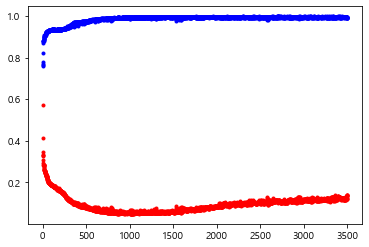

In [12]:
# 테스트셋으로 실험결과의 오차 값을 저장
y_vloss = history.history['val_loss']
# 트레이닝셋으로 측정한 정확도의 값을 저장
y_acc = history.history['accuracy']

# x 값(epoch 수)을 기준으로 오차값은 빨간색, 정확도는 파란색으로 표기
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)
plt.show()

## 8. 학습의 자동 종료 설정
* 참고 : 실제 코드에서는 6, 7번을 수행하지 않고 돌려야 정확한 결과를 얻을 수 있다

In [11]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

In [12]:
model.fit(X, Y, validation_split=0.33, epochs=3500, batch_size=500, verbose=0, callbacks=[early_stopping_callback, checkpointer])


Epoch 00001: val_loss improved from inf to 0.57325, saving model to ./model/01-0.5733.hdf5

Epoch 00002: val_loss improved from 0.57325 to 0.41489, saving model to ./model/02-0.4149.hdf5

Epoch 00003: val_loss improved from 0.41489 to 0.32586, saving model to ./model/03-0.3259.hdf5

Epoch 00004: val_loss did not improve from 0.32586

Epoch 00005: val_loss did not improve from 0.32586

Epoch 00006: val_loss did not improve from 0.32586

Epoch 00007: val_loss improved from 0.32586 to 0.30750, saving model to ./model/07-0.3075.hdf5

Epoch 00008: val_loss improved from 0.30750 to 0.29054, saving model to ./model/08-0.2905.hdf5

Epoch 00009: val_loss improved from 0.29054 to 0.28410, saving model to ./model/09-0.2841.hdf5

Epoch 00010: val_loss improved from 0.28410 to 0.28347, saving model to ./model/10-0.2835.hdf5

Epoch 00011: val_loss did not improve from 0.28347

Epoch 00012: val_loss did not improve from 0.28347

Epoch 00013: val_loss improved from 0.28347 to 0.28199, saving model to


Epoch 00094: val_loss improved from 0.18913 to 0.18877, saving model to ./model/94-0.1888.hdf5

Epoch 00095: val_loss improved from 0.18877 to 0.18851, saving model to ./model/95-0.1885.hdf5

Epoch 00096: val_loss improved from 0.18851 to 0.18822, saving model to ./model/96-0.1882.hdf5

Epoch 00097: val_loss improved from 0.18822 to 0.18787, saving model to ./model/97-0.1879.hdf5

Epoch 00098: val_loss improved from 0.18787 to 0.18746, saving model to ./model/98-0.1875.hdf5

Epoch 00099: val_loss improved from 0.18746 to 0.18701, saving model to ./model/99-0.1870.hdf5

Epoch 00100: val_loss did not improve from 0.18701

Epoch 00101: val_loss did not improve from 0.18701

Epoch 00102: val_loss did not improve from 0.18701

Epoch 00103: val_loss improved from 0.18701 to 0.18678, saving model to ./model/103-0.1868.hdf5

Epoch 00104: val_loss improved from 0.18678 to 0.18579, saving model to ./model/104-0.1858.hdf5

Epoch 00105: val_loss improved from 0.18579 to 0.18552, saving model to .

Epoch 00212: val_loss improved from 0.15508 to 0.15378, saving model to ./model/212-0.1538.hdf5

Epoch 00213: val_loss improved from 0.15378 to 0.15343, saving model to ./model/213-0.1534.hdf5

Epoch 00214: val_loss did not improve from 0.15343

Epoch 00215: val_loss did not improve from 0.15343

Epoch 00216: val_loss did not improve from 0.15343

Epoch 00217: val_loss improved from 0.15343 to 0.15272, saving model to ./model/217-0.1527.hdf5

Epoch 00218: val_loss improved from 0.15272 to 0.15144, saving model to ./model/218-0.1514.hdf5

Epoch 00219: val_loss improved from 0.15144 to 0.15135, saving model to ./model/219-0.1514.hdf5

Epoch 00220: val_loss improved from 0.15135 to 0.15086, saving model to ./model/220-0.1509.hdf5

Epoch 00221: val_loss did not improve from 0.15086

Epoch 00222: val_loss did not improve from 0.15086

Epoch 00223: val_loss did not improve from 0.15086

Epoch 00224: val_loss improved from 0.15086 to 0.15027, saving model to ./model/224-0.1503.hdf5

Epoch 002

Epoch 00329: val_loss improved from 0.10557 to 0.10551, saving model to ./model/329-0.1055.hdf5

Epoch 00330: val_loss did not improve from 0.10551

Epoch 00331: val_loss did not improve from 0.10551

Epoch 00332: val_loss improved from 0.10551 to 0.10466, saving model to ./model/332-0.1047.hdf5

Epoch 00333: val_loss improved from 0.10466 to 0.10365, saving model to ./model/333-0.1036.hdf5

Epoch 00334: val_loss did not improve from 0.10365

Epoch 00335: val_loss did not improve from 0.10365

Epoch 00336: val_loss improved from 0.10365 to 0.10317, saving model to ./model/336-0.1032.hdf5

Epoch 00337: val_loss did not improve from 0.10317

Epoch 00338: val_loss did not improve from 0.10317

Epoch 00339: val_loss did not improve from 0.10317

Epoch 00340: val_loss did not improve from 0.10317

Epoch 00341: val_loss did not improve from 0.10317

Epoch 00342: val_loss did not improve from 0.10317

Epoch 00343: val_loss did not improve from 0.10317

Epoch 00344: val_loss improved from 0.10

Epoch 00472: val_loss improved from 0.08119 to 0.07896, saving model to ./model/472-0.0790.hdf5

Epoch 00473: val_loss did not improve from 0.07896

Epoch 00474: val_loss did not improve from 0.07896

Epoch 00475: val_loss did not improve from 0.07896

Epoch 00476: val_loss did not improve from 0.07896

Epoch 00477: val_loss did not improve from 0.07896

Epoch 00478: val_loss did not improve from 0.07896

Epoch 00479: val_loss did not improve from 0.07896

Epoch 00480: val_loss did not improve from 0.07896

Epoch 00481: val_loss did not improve from 0.07896

Epoch 00482: val_loss did not improve from 0.07896

Epoch 00483: val_loss did not improve from 0.07896

Epoch 00484: val_loss improved from 0.07896 to 0.07875, saving model to ./model/484-0.0788.hdf5

Epoch 00485: val_loss improved from 0.07875 to 0.07804, saving model to ./model/485-0.0780.hdf5

Epoch 00486: val_loss did not improve from 0.07804

Epoch 00487: val_loss did not improve from 0.07804

Epoch 00488: val_loss did not imp


Epoch 00623: val_loss did not improve from 0.06250

Epoch 00624: val_loss did not improve from 0.06250

Epoch 00625: val_loss did not improve from 0.06250

Epoch 00626: val_loss did not improve from 0.06250

Epoch 00627: val_loss did not improve from 0.06250

Epoch 00628: val_loss did not improve from 0.06250

Epoch 00629: val_loss did not improve from 0.06250

Epoch 00630: val_loss did not improve from 0.06250

Epoch 00631: val_loss did not improve from 0.06250

Epoch 00632: val_loss did not improve from 0.06250

Epoch 00633: val_loss did not improve from 0.06250

Epoch 00634: val_loss improved from 0.06250 to 0.06180, saving model to ./model/634-0.0618.hdf5

Epoch 00635: val_loss did not improve from 0.06180

Epoch 00636: val_loss did not improve from 0.06180

Epoch 00637: val_loss did not improve from 0.06180

Epoch 00638: val_loss did not improve from 0.06180

Epoch 00639: val_loss did not improve from 0.06180

Epoch 00640: val_loss did not improve from 0.06180

Epoch 00641: val_l


Epoch 00775: val_loss did not improve from 0.05319

Epoch 00776: val_loss did not improve from 0.05319

Epoch 00777: val_loss did not improve from 0.05319

Epoch 00778: val_loss did not improve from 0.05319

Epoch 00779: val_loss did not improve from 0.05319

Epoch 00780: val_loss improved from 0.05319 to 0.05282, saving model to ./model/780-0.0528.hdf5

Epoch 00781: val_loss did not improve from 0.05282

Epoch 00782: val_loss did not improve from 0.05282

Epoch 00783: val_loss did not improve from 0.05282

Epoch 00784: val_loss did not improve from 0.05282

Epoch 00785: val_loss did not improve from 0.05282

Epoch 00786: val_loss did not improve from 0.05282

Epoch 00787: val_loss did not improve from 0.05282

Epoch 00788: val_loss improved from 0.05282 to 0.05244, saving model to ./model/788-0.0524.hdf5

Epoch 00789: val_loss did not improve from 0.05244

Epoch 00790: val_loss did not improve from 0.05244

Epoch 00791: val_loss did not improve from 0.05244

Epoch 00792: val_loss did

Epoch 00927: val_loss did not improve from 0.04845

Epoch 00928: val_loss did not improve from 0.04845

Epoch 00929: val_loss did not improve from 0.04845

Epoch 00930: val_loss did not improve from 0.04845

Epoch 00931: val_loss did not improve from 0.04845

Epoch 00932: val_loss did not improve from 0.04845

Epoch 00933: val_loss did not improve from 0.04845

Epoch 00934: val_loss did not improve from 0.04845

Epoch 00935: val_loss did not improve from 0.04845

Epoch 00936: val_loss did not improve from 0.04845

Epoch 00937: val_loss did not improve from 0.04845

Epoch 00938: val_loss did not improve from 0.04845

Epoch 00939: val_loss did not improve from 0.04845

Epoch 00940: val_loss did not improve from 0.04845

Epoch 00941: val_loss did not improve from 0.04845

Epoch 00942: val_loss did not improve from 0.04845

Epoch 00943: val_loss did not improve from 0.04845

Epoch 00944: val_loss did not improve from 0.04845

Epoch 00945: val_loss did not improve from 0.04845

Epoch 00946:

In [13]:
print("Accuray : %.4f" % (model.evaluate(X, Y)[1]))

975/975 [==============================] - 0s 29us/sample - loss: 0.0339 - accuracy: 0.9918
Accuray : 0.9918
